In [1]:
from pathlib import Path

# Project root (one level above notebooks/)
PROJECT_ROOT = Path("..").resolve()

DATA_DIR = PROJECT_ROOT / "data"
OUTPUT_DIR = PROJECT_ROOT / "outputs"
SHAPEFILE_DIR = DATA_DIR / "shapefile"

print("Project root:", PROJECT_ROOT)


Project root: D:\MSc. Data Science\SEM - 4\UDAI HACKATHON\UIDAI_Operational_Stress


In [1]:
import pandas as pd
import glob
import numpy as np


In [2]:
enrolment_full = pd.concat(
    [pd.read_csv(f) for f in glob.glob("api_data_aadhar_enrolment_*.csv")],
    ignore_index=True
)

demographic_full = pd.concat(
    [pd.read_csv(f) for f in glob.glob("api_data_aadhar_demographic_*.csv")],
    ignore_index=True
)

biometric_full = pd.concat(
    [pd.read_csv(f) for f in glob.glob("api_data_aadhar_biometric_*.csv")],
    ignore_index=True
)

for df in [enrolment_full, demographic_full, biometric_full]:
    df["date"] = pd.to_datetime(df["date"], errors="coerce")


In [3]:
start = pd.to_datetime("2025-04-01")
end   = pd.to_datetime("2025-10-31")

enrol_time = enrolment_full[(enrolment_full["date"] >= start) & (enrolment_full["date"] <= end)]
demo_time  = demographic_full[(demographic_full["date"] >= start) & (demographic_full["date"] <= end)]
bio_time   = biometric_full[(biometric_full["date"] >= start) & (biometric_full["date"] <= end)]


In [4]:
def daily_total(df):
    age_cols = [c for c in df.columns if "age" in c.lower()]
    return (
        df.groupby("date")[age_cols]
          .sum()
          .sum(axis=1)
          .reset_index(name="total")
    )

enrol_daily = daily_total(enrol_time).rename(columns={"total": "enrolment"})
demo_daily  = daily_total(demo_time).rename(columns={"total": "demographic"})
bio_daily   = daily_total(bio_time).rename(columns={"total": "biometric"})


In [5]:
time_compare = (
    enrol_daily
    .merge(demo_daily, on="date")
    .merge(bio_daily, on="date")
)

print("Reporting days:", time_compare.shape[0])


Reporting days: 14


In [6]:
time_compare["demo_to_enrol_ratio"] = (
    time_compare["demographic"] / time_compare["enrolment"]
)

time_compare["bio_to_enrol_ratio"] = (
    time_compare["biometric"] / time_compare["enrolment"]
)


In [7]:
time_compare["demo_z"] = (
    time_compare["demo_to_enrol_ratio"] -
    time_compare["demo_to_enrol_ratio"].mean()
) / time_compare["demo_to_enrol_ratio"].std()

time_compare["bio_z"] = (
    time_compare["bio_to_enrol_ratio"] -
    time_compare["bio_to_enrol_ratio"].mean()
) / time_compare["bio_to_enrol_ratio"].std()

time_compare["temporal_anomaly"] = (
    (time_compare["demo_z"].abs() > 2.5) |
    (time_compare["bio_z"].abs() > 2.5)
)

time_compare[time_compare["temporal_anomaly"]]


,date,enrolment,demographic,biometric,demo_to_enrol_ratio,bio_to_enrol_ratio,demo_z,bio_z,temporal_anomaly
1,2025-04-11,1007,529318,288485,525.63853,286.479643,3.473628,3.473263,True


In [8]:
# Aggregate by district (reuse same logic)
def agg_by_district(df):
    age_cols = [c for c in df.columns if "age" in c.lower()]
    return (
        df.groupby("district")[age_cols]
          .sum()
          .sum(axis=1)
          .reset_index(name="total")
    )

enrol_dist = agg_by_district(enrol_time).rename(columns={"total": "enrolment"})
demo_dist  = agg_by_district(demo_time).rename(columns={"total": "demographic"})
bio_dist   = agg_by_district(bio_time).rename(columns={"total": "biometric"})

geo = (
    enrol_dist
    .merge(demo_dist, on="district")
    .merge(bio_dist, on="district")
)

# Remove low-denominator noise
geo = geo[geo["enrolment"] >= 100]

# Ratios
geo["demo_ratio"] = geo["demographic"] / geo["enrolment"]
geo["bio_ratio"]  = geo["biometric"] / geo["enrolment"]

print("Districts analysed:", geo.shape[0])


Districts analysed: 727


In [9]:
# Demographic anomalies
demo_median = geo["demo_ratio"].median()
demo_mad = np.median(np.abs(geo["demo_ratio"] - demo_median))

geo["demo_mad_score"] = (geo["demo_ratio"] - demo_median) / demo_mad
geo["demo_spatial_anomaly"] = geo["demo_mad_score"].abs() > 5

# Biometric anomalies
bio_median = geo["bio_ratio"].median()
bio_mad = np.median(np.abs(geo["bio_ratio"] - bio_median))

geo["bio_mad_score"] = (geo["bio_ratio"] - bio_median) / bio_mad
geo["bio_spatial_anomaly"] = geo["bio_mad_score"].abs() > 5


In [10]:
geo[
    (geo["demo_spatial_anomaly"]) |
    (geo["bio_spatial_anomaly"])
][[
    "district",
    "demo_ratio",
    "bio_ratio",
    "demo_mad_score",
    "bio_mad_score"
]].sort_values(
    ["demo_mad_score", "bio_mad_score"],
    ascending=False
).head(10)


,district,demo_ratio,bio_ratio,demo_mad_score,bio_mad_score
329,Imphal West,86.125604,48.574879,23.824769,12.025179
824,Thoubal,82.704762,37.319048,22.751824,8.639794
328,Imphal East,63.865741,33.375000,16.842978,7.453553
122,Bishnupur,62.597484,22.540881,16.445191,4.195005
904,Yavatmal,45.468815,43.611227,11.072796,10.532275
149,Chandrapur,42.508503,43.290816,10.144296,10.435906
572,Nanded,39.410108,27.674368,9.172487,5.738990
318,Hingoli,39.041812,25.019164,9.056971,4.940391
611,Osmanabad,37.946860,23.732689,8.713540,4.553462
132,Buldana,34.250000,30.402439,7.554022,6.559504


In [11]:
# Normalize components (robust)
geo["demo_norm"] = geo["demo_ratio"] / geo["demo_ratio"].median()
geo["bio_norm"]  = geo["bio_ratio"] / geo["bio_ratio"].median()
geo["enrol_norm"] = geo["enrolment"] / geo["enrolment"].median()

# Escalation Risk Index (interpretable weights)
geo["escalation_risk"] = (
    0.45 * geo["demo_norm"] +
    0.35 * geo["bio_norm"] -
    0.20 * geo["enrol_norm"]  # low enrolment = higher risk
)

geo.sort_values("escalation_risk", ascending=False).head(10)


,district,enrolment,demographic,biometric,demo_ratio,bio_ratio,demo_mad_score,demo_spatial_anomaly,bio_mad_score,bio_spatial_anomaly,demo_norm,bio_norm,enrol_norm,escalation_risk
329,Imphal West,207,17828,10055,86.125604,48.574879,23.824769,True,12.025179,True,8.472174,5.652709,0.274536,5.736019
824,Thoubal,210,17368,7837,82.704762,37.319048,22.751824,True,8.639794,True,8.135666,4.342857,0.278515,5.125346
328,Imphal East,216,13795,7209,63.865741,33.375000,16.842978,True,7.453553,True,6.282471,3.883884,0.286472,4.129177
122,Bishnupur,159,9953,3584,62.597484,22.540881,16.445191,True,4.195005,False,6.157713,2.623106,0.210875,3.646883
904,Yavatmal,962,43741,41954,45.468815,43.611227,11.072796,True,10.532275,True,4.472766,5.075084,1.275862,3.533852
149,Chandrapur,588,24995,25455,42.508503,43.290816,10.144296,True,10.435906,True,4.181561,5.037798,0.779841,3.488963
263,Gadchiroli,412,10285,20761,24.963592,50.390777,4.641347,False,12.571342,True,2.455668,5.864027,0.546419,3.048176
689,Ratnagiri,419,11279,19582,26.918854,46.735084,5.254614,True,11.471829,True,2.648007,5.438611,0.555703,2.983976
879,Washim,410,12225,17356,29.817073,42.331707,6.163638,True,10.147438,True,2.933105,4.926185,0.543767,2.935309
106,Bhandara,291,7850,11521,26.975945,39.591065,5.272520,True,9.323142,True,2.653623,4.607254,0.385942,2.729481


In [12]:
future_risk = geo[
    (~geo["demo_spatial_anomaly"]) &
    (~geo["bio_spatial_anomaly"])
].sort_values("escalation_risk", ascending=False).head(10)

future_risk[[
    "district",
    "demo_ratio",
    "bio_ratio",
    "escalation_risk"
]]


,district,demo_ratio,bio_ratio,escalation_risk
355,Jashpur,20.960373,24.030303,1.792800
64,Baloda Bazar,23.074567,23.519308,1.780164
393,Kanker,18.589474,24.585965,1.748677
417,Kawardha,20.106494,22.480519,1.703550
272,Gariyaband,18.598662,22.785953,1.672056
444,Kolhapur,23.445440,23.214984,1.657661
97,Bemetara,15.489362,24.756286,1.556845
782,South Goa,20.528409,16.982955,1.553750
85,Barnala,15.187919,22.375839,1.544158
676,Rajnandgaon,17.957560,23.228117,1.540996


In [13]:
# --- Load & prepare (run once) ---
import pandas as pd, numpy as np, glob
import matplotlib.pyplot as plt

# load slices (adjust path if necessary)
enrol = pd.concat([pd.read_csv(f) for f in glob.glob("api_data_aadhar_enrolment_*.csv")], ignore_index=True)
demo  = pd.concat([pd.read_csv(f) for f in glob.glob("api_data_aadhar_demographic_*.csv")], ignore_index=True)
bio   = pd.concat([pd.read_csv(f) for f in glob.glob("api_data_aadhar_biometric_*.csv")], ignore_index=True)

for df in (enrol,demo,bio):
    df['date'] = pd.to_datetime(df['date'], errors='coerce')

start = pd.to_datetime("2025-04-01"); end = pd.to_datetime("2025-10-31")
enrol = enrol[(enrol['date']>=start)&(enrol['date']<=end)]
demo  = demo[(demo['date']>=start)&(demo['date']<=end)]
bio   = bio[(bio['date']>=start)&(bio['date']<=end)]

def agg_by_district(df):
    age_cols = [c for c in df.columns if "age" in c.lower()]
    agg = df.groupby('district')[age_cols].sum()
    agg['total'] = agg.sum(axis=1)
    return agg['total'].reset_index(name='total')

enrol_d = agg_by_district(enrol).rename(columns={'total':'enrolment'})
demo_d  = agg_by_district(demo).rename(columns={'total':'demographic'})
bio_d   = agg_by_district(bio).rename(columns={'total':'biometric'})

geo = enrol_d.merge(demo_d, on='district').merge(bio_d, on='district')
geo = geo[geo['enrolment']>=100]  # threshold
geo['demo_ratio'] = geo['demographic'] / geo['enrolment']
geo['bio_ratio']  = geo['biometric'] / geo['enrolment']

# MAD scores
demo_med = np.median(geo['demo_ratio'])
demo_mad = np.median(np.abs(geo['demo_ratio'] - demo_med)) or 1.0
bio_med  = np.median(geo['bio_ratio'])
bio_mad  = np.median(np.abs(geo['bio_ratio'] - bio_med)) or 1.0

geo['demo_mad_score'] = (geo['demo_ratio'] - demo_med) / demo_mad
geo['bio_mad_score']  = (geo['bio_ratio'] - bio_med)  / bio_mad
geo['demo_spatial_anomaly'] = geo['demo_mad_score'].abs() > 5
geo['bio_spatial_anomaly']  = geo['bio_mad_score'].abs()  > 5

# escalation index
geo['demo_norm'] = geo['demo_ratio'] / np.median(geo['demo_ratio'])
geo['bio_norm']  = geo['bio_ratio'] / np.median(geo['bio_ratio'])
geo['enrol_norm'] = geo['enrolment'] / np.median(geo['enrolment'])
geo['escalation_risk'] = 0.45*geo['demo_norm'] + 0.35*geo['bio_norm'] - 0.20*geo['enrol_norm']

# Save CSV for sharing
geo.reset_index().to_csv('geo_stress_table.csv', index=False)


In [14]:
def daily_for_district(name):
    # select age columns only
    enrol_age_cols = [c for c in enrol.columns if "age" in c.lower()]
    demo_age_cols  = [c for c in demo.columns if "age" in c.lower()]
    bio_age_cols   = [c for c in bio.columns if "age" in c.lower()]

    e = (
        enrol[enrol["district"] == name]
        .groupby("date")[enrol_age_cols]
        .sum()
        .sum(axis=1)
    )

    d = (
        demo[demo["district"] == name]
        .groupby("date")[demo_age_cols]
        .sum()
        .sum(axis=1)
    )

    b = (
        bio[bio["district"] == name]
        .groupby("date")[bio_age_cols]
        .sum()
        .sum(axis=1)
    )

    df = pd.concat([e, d, b], axis=1).fillna(0)
    df.columns = ["enrolment", "demographic", "biometric"]
    return df


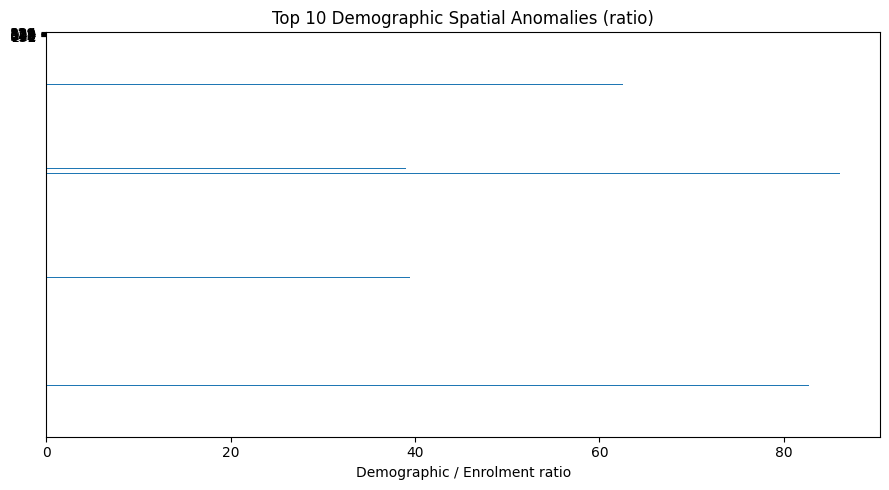

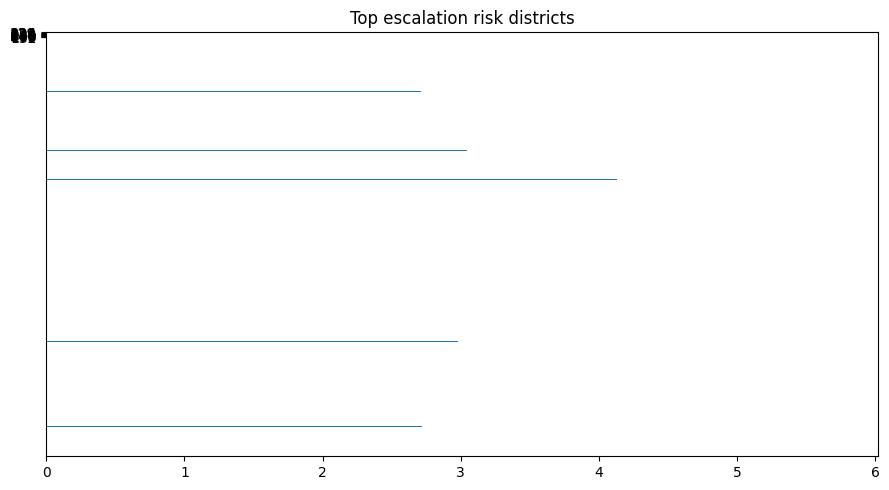

In [15]:
# Top 10 demo anomalies bar chart
top_demo = geo.sort_values('demo_mad_score', ascending=False).head(10)
plt.figure(figsize=(9,5))
plt.barh(top_demo.index, top_demo['demo_ratio'])
plt.yticks(range(len(top_demo)), top_demo.index)
plt.xlabel('Demographic / Enrolment ratio')
plt.title('Top 10 Demographic Spatial Anomalies (ratio)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('top10_demo_anomalies.png', dpi=150)
plt.show()

# Top 10 escalation risk
top_risk = geo.sort_values('escalation_risk', ascending=False).head(12)
plt.figure(figsize=(9,5))
plt.barh(top_risk.index, top_risk['escalation_risk'])
plt.yticks(range(len(top_risk)), top_risk.index)
plt.title('Top escalation risk districts')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('top_escalation_risk.png', dpi=150)
plt.show()


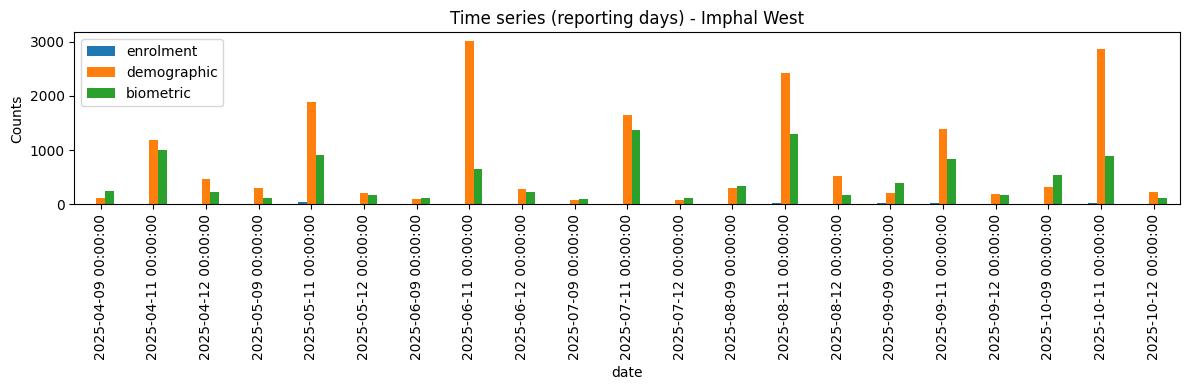

Enrol age totals: {'age_0_5': 111, 'age_5_17': 92, 'age_18_greater': 4}
Demo age totals: {'demo_age_5_17': 1949, 'demo_age_17_': 15879}
Bio age totals: {'bio_age_5_17': 5898, 'bio_age_17_': 4157}


In [16]:
# 1) time series for a district
name = 'Imphal West'
df = daily_for_district(name)
df.plot(kind='bar', figsize=(12,4))
plt.title(f"Time series (reporting days) - {name}")
plt.ylabel("Counts")
plt.tight_layout()
plt.savefig(f"{name}_time_series.png", dpi=150)
plt.show()

# 2) age-share for this district (aggregate)
def age_share_for_district(dname):
    edf = enrol[enrol['district']==dname]; dd=demo[demo['district']==dname]; bd=bio[bio['district']==dname]
    e_age = edf[[c for c in edf.columns if 'age' in c.lower()]].sum()
    d_age = dd[[c for c in dd.columns if 'age' in c.lower()]].sum()
    b_age = bd[[c for c in bd.columns if 'age' in c.lower()]].sum()
    return e_age, d_age, b_age

e_age, d_age, b_age = age_share_for_district(name)
print("Enrol age totals:", e_age.to_dict())
print("Demo age totals:", d_age.to_dict())
print("Bio age totals:", b_age.to_dict())


In [17]:
for thr in [4,5,6,7]:
    print("thr",thr, "demo anomalies:", (geo['demo_mad_score'].abs()>thr).sum(),
          "bio anomalies:", (geo['bio_mad_score'].abs()>thr).sum())


thr 4 demo anomalies: 39 bio anomalies: 52
thr 5 demo anomalies: 27 bio anomalies: 32
thr 6 demo anomalies: 15 bio anomalies: 24
thr 7 demo anomalies: 11 bio anomalies: 16


## Predictive Objective & Constraints

This dataset contains **periodic reporting snapshots**, not continuous daily logs.
Therefore, prediction focuses on **future reporting-cycle load**, not daily counts.

Goal:
- Project demographic and biometric activity over the next ~30 days
- Detect whether load is trending upward, stable, or declining
- Provide an early-warning indicator, not a precise daily forecast


In [21]:
# Build clean national time series from reporting days
# Using already-aggregated daily tables (correct column names)

ts = (
    enrol_daily
    .merge(demo_daily, on="date", how="inner")
    .merge(bio_daily, on="date", how="inner")
    .sort_values("date")
    .reset_index(drop=True)
)

ts


,date,enrolment,demographic,biometric
0,2025-04-09,65349,383726,301023
1,2025-04-11,1007,529318,288485
2,2025-05-09,26069,273954,95781
3,2025-05-11,75593,259691,356460
4,2025-06-09,58957,368240,254489
5,2025-06-11,43585,592379,418932
6,2025-07-09,14658,89031,32956
7,2025-07-11,42330,467135,370870
8,2025-08-09,83353,535632,415718
9,2025-08-11,52391,479859,358113


<Axes: title={'center': 'National UIDAI Update Load (Reporting Days)'}, xlabel='date'>

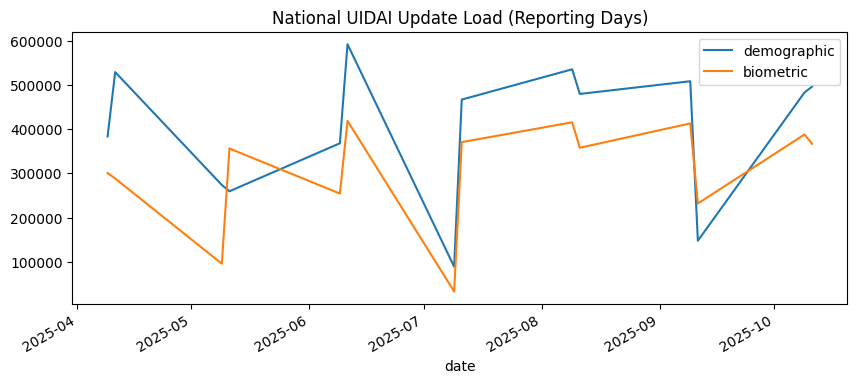

In [22]:
ts.plot(
    x="date",
    y=["demographic", "biometric"],
    figsize=(10,4),
    title="National UIDAI Update Load (Reporting Days)"
)


In [23]:
from sklearn.linear_model import LinearRegression
import numpy as np

ts["t"] = np.arange(len(ts))

def linear_forecast(series, steps=30):
    X = ts[["t"]]
    y = series.values
    model = LinearRegression()
    model.fit(X, y)
    future_t = np.arange(len(ts), len(ts) + steps).reshape(-1, 1)
    forecast = model.predict(future_t)
    return forecast, model.coef_[0]

bio_forecast_lin, bio_slope = linear_forecast(ts["biometric"])
demo_forecast_lin, demo_slope = linear_forecast(ts["demographic"])

bio_slope, demo_slope


c:\Users\amogh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\amogh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


(9720.896703296707, 5125.382417582417)

In [24]:
window = 3
ts["bio_momentum"] = ts["biometric"].diff().rolling(window).mean()
ts["demo_momentum"] = ts["demographic"].diff().rolling(window).mean()

ts[["date", "bio_momentum", "demo_momentum"]]


,date,bio_momentum,demo_momentum
0,2025-04-09,NaN,NaN
1,2025-04-11,NaN,NaN
2,2025-05-09,NaN,NaN
3,2025-05-11,18479.000000,-41345.000000
4,2025-06-09,-11332.000000,-53692.666667
5,2025-06-11,107717.000000,106141.666667
6,2025-07-09,-107834.666667,-56886.666667
7,2025-07-11,38793.666667,32965.000000
8,2025-08-09,-1071.333333,-18915.666667
9,2025-08-11,108385.666667,130276.000000


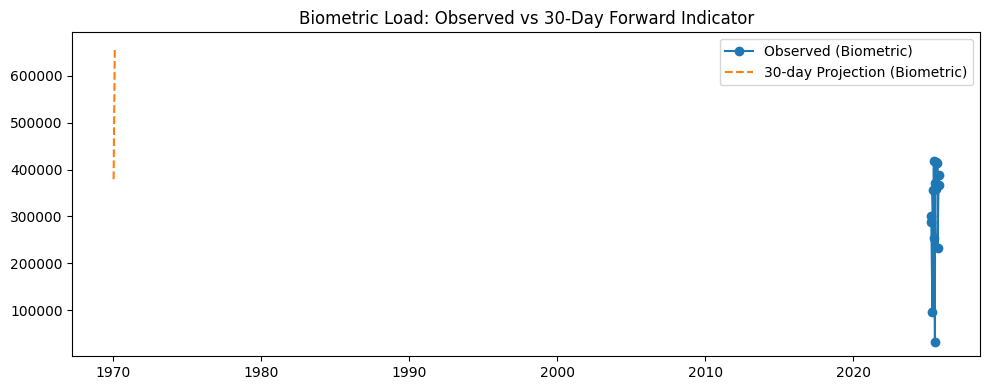

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(ts["date"], ts["biometric"], marker="o", label="Observed (Biometric)")
plt.plot(
    range(len(ts), len(ts) + 30),
    bio_forecast_lin,
    linestyle="--",
    label="30-day Projection (Biometric)"
)
plt.title("Biometric Load: Observed vs 30-Day Forward Indicator")
plt.legend()
plt.tight_layout()
plt.show()


In [26]:
def trend_signal(slope, momentum):
    if slope > 0 and momentum > 0:
        return "Escalating"
    if slope < 0 and momentum < 0:
        return "Easing"
    return "Stable"

bio_signal = trend_signal(bio_slope, ts["bio_momentum"].iloc[-1])
demo_signal = trend_signal(demo_slope, ts["demo_momentum"].iloc[-1])

bio_signal, demo_signal


('Stable', 'Stable')

# -------------------------------
# PREDICTIVE INPUT CONTRACT
# -------------------------------

required = {
    "enrol_daily": enrol_daily,
    "demo_daily": demo_daily,
    "bio_daily": bio_daily
}

for name, df in required.items():
    print(name, df.columns.tolist(), "rows:", len(df))


In [27]:
# -------------------------------
# NATIONAL PREDICTIVE TIMESERIES
# -------------------------------

ts = (
    enrol_daily
    .merge(demo_daily, on="date", how="inner")
    .merge(bio_daily, on="date", how="inner")
    .sort_values("date")
    .reset_index(drop=True)
)

ts


,date,enrolment,demographic,biometric
0,2025-04-09,65349,383726,301023
1,2025-04-11,1007,529318,288485
2,2025-05-09,26069,273954,95781
3,2025-05-11,75593,259691,356460
4,2025-06-09,58957,368240,254489
5,2025-06-11,43585,592379,418932
6,2025-07-09,14658,89031,32956
7,2025-07-11,42330,467135,370870
8,2025-08-09,83353,535632,415718
9,2025-08-11,52391,479859,358113


In [28]:
from sklearn.linear_model import LinearRegression
import numpy as np

ts["t"] = np.arange(len(ts))

def slope(series):
    model = LinearRegression()
    model.fit(ts[["t"]], series.values)
    return model.coef_[0]

bio_slope  = slope(ts["biometric"])
demo_slope = slope(ts["demographic"])

ts["bio_momentum"]  = ts["biometric"].diff().rolling(3).mean()
ts["demo_momentum"] = ts["demographic"].diff().rolling(3).mean()

bio_slope, demo_slope


(9720.896703296707, 5125.382417582417)

In [29]:
def classify_trend(slope, momentum):
    if slope > 0 and momentum > 0:
        return "Escalating"
    if slope < 0 and momentum < 0:
        return "Easing"
    return "Stable"

bio_signal  = classify_trend(bio_slope, ts["bio_momentum"].iloc[-1])
demo_signal = classify_trend(demo_slope, ts["demo_momentum"].iloc[-1])

bio_signal, demo_signal


('Stable', 'Stable')

## 30-Day Forward Indicator (Predictive Insight)

Using:
- linear trend direction (slope)
- recent reporting-cycle momentum

We classify the near-term UIDAI workload outlook as:

- **Biometric updates:** *{bio_signal}*
- **Demographic updates:** *{demo_signal}*

This indicator is designed to support **proactive capacity planning**
rather than precise volume forecasting.


### Predictive Limitations

- Forecasts are based on reporting snapshots, not daily logs.
- Signals indicate **direction and risk**, not exact volumes.
- Intended for monthly operational planning and early warning.
